## Weaviate 1.31 Enablement session

### Prep

In [1]:
from helpers import get_model_and_processor
import dotenv

dotenv.load_dotenv(verbose=True)
model, processor = get_model_and_processor()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



### Key features

- MUVERA encoding algorithm for multi-vector embeddings
    - Efficiently use state-of-the-art multi-vector models
- Vectorizer changes
    - Adapt to changing needs by adding new object vectors as needed
- Shard movement between nodes (experimental)
    - Easier scaling & adaptability in multi-node clusters
- HNSW snapshotting
    - Faster bootup - big bonus for big datasets


In [2]:
import weaviate
import os

client = weaviate.connect_to_local(
    headers={
        "X-Cohere-Api-Key": os.getenv("COHERE_API_KEY"),
    }
)

In [3]:
client.get_meta()["version"]

'1.31.0-rc.0'

Check the cluster setup:

In [4]:
client.cluster.nodes()

[Node(git_hash='9ef4fcb', name='node1', shards=None, stats=None, status='HEALTHY', version='1.31.0-rc.0'),
 Node(git_hash='9ef4fcb', name='node2', shards=None, stats=None, status='HEALTHY', version='1.31.0-rc.0'),
 Node(git_hash='9ef4fcb', name='node3', shards=None, stats=None, status='HEALTHY', version='1.31.0-rc.0')]

## MUVERA

### Reminder re: multi-vector embeddings

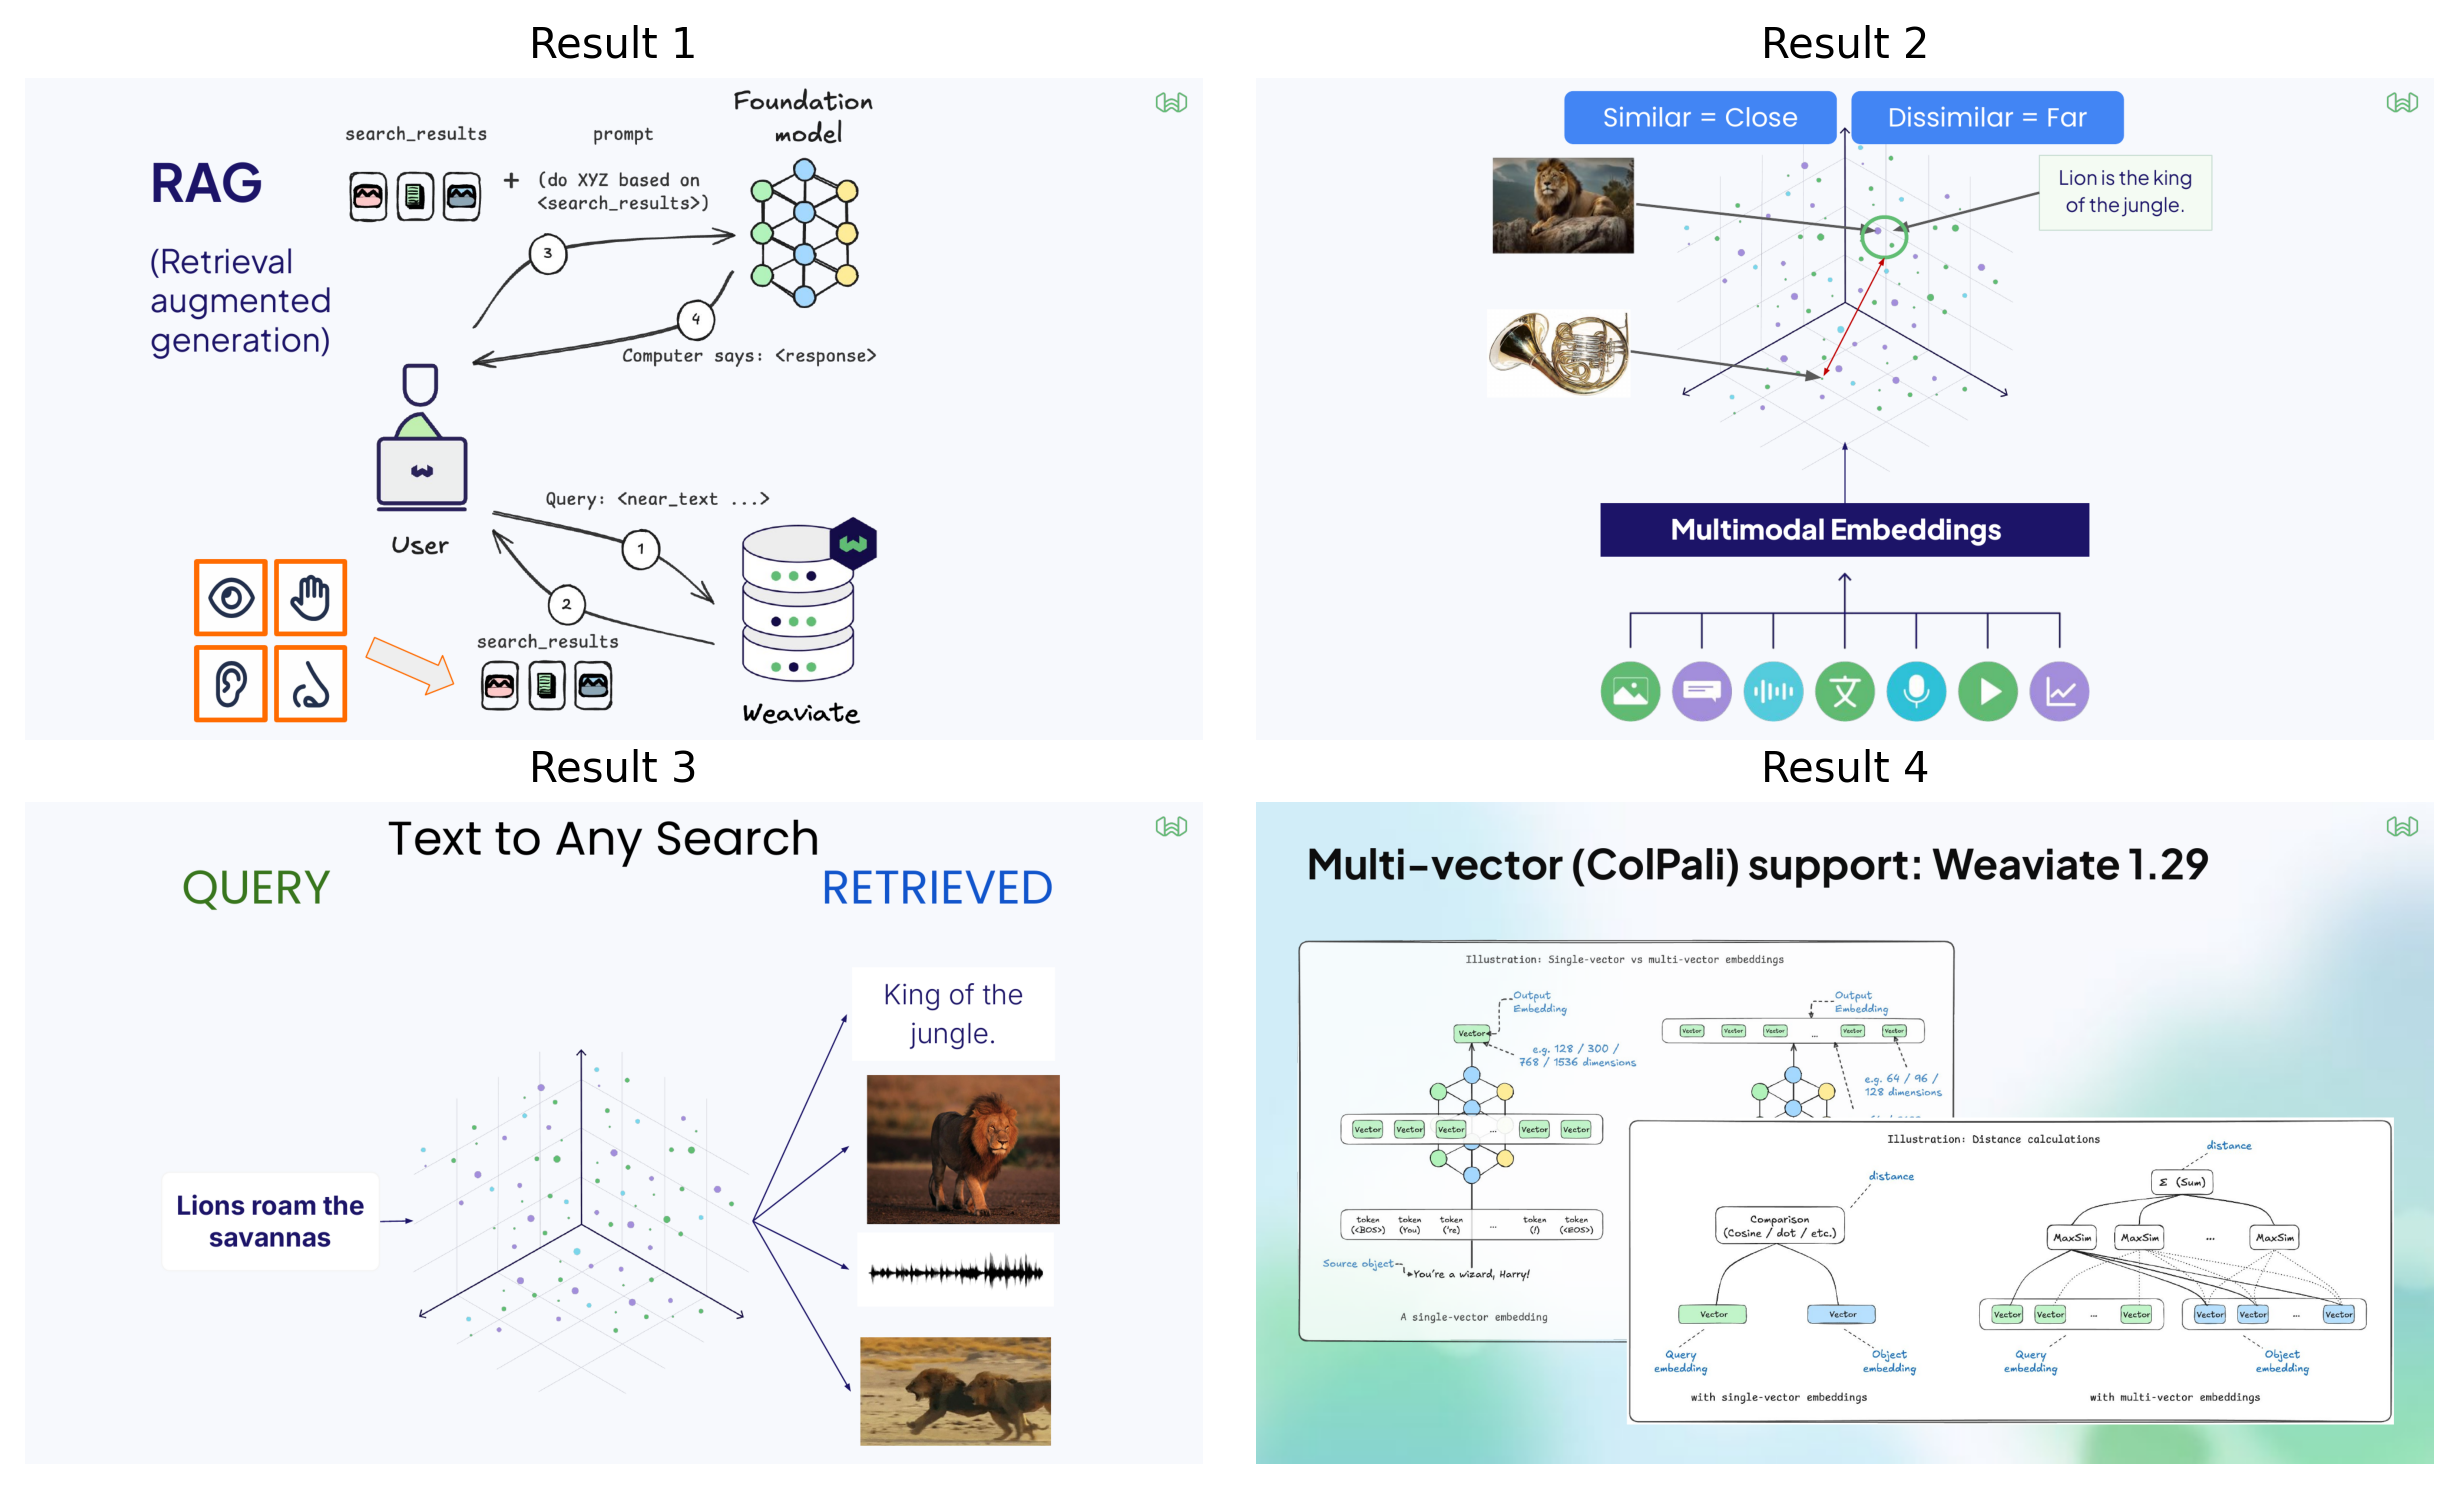

In [5]:
from helpers import show_local_imgs
from pathlib import Path

paths = sorted(list(Path("data/slides/imgs").glob("202504_roadshow_mm_talk_*.png")))

show_local_imgs([paths[12], paths[22], paths[32], paths[55]])

> ### 🤔 Can I search these as images ⬆️

In [6]:
from weaviate.classes.config import Configure, Property, DataType, Tokenization

collection_name = "TempCollection"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="text", data_type=DataType.TEXT),
        Property(name="image", data_type=DataType.BLOB),
        Property(name="filepath", data_type=DataType.TEXT, tokenization=Tokenization.FIELD),
    ],
    vectorizer_config=[
        Configure.NamedVectors.none(
            name="colpali",  # colpali_v1_3 vector
            vector_index_config=Configure.VectorIndex.hnsw(
                multi_vector=Configure.VectorIndex.MultiVector.multi_vector()
            )
        ),
    ],
    replication_config=Configure.replication(factor=3)
)

/Users/jphwang/code/sandpit/weaviate_enablement_1_31/.venv/lib/python3.12/site-packages/weaviate/collections/classes/config.py:1977: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  for cls_field in self.model_fields:


In [7]:
from pathlib import Path
import base64
import numpy as np

imgs_dir = Path("data/slides/imgs")
embs_dir = Path("data/slides/embeddings")

embeddings_file = embs_dir / "202504_roadshow_mm_talk_embeddings.npz"
embeddings = np.load(embeddings_file)

In [8]:
from tqdm import tqdm

collection = client.collections.get(collection_name)

with collection.batch.fixed_size(20) as batch:
    for i, embedding in tqdm(enumerate(embeddings["embeddings"])):
        filename = embeddings["filepaths"][i].split("/")[-1]
        img_path = imgs_dir/filename
        batch.add_object(
            properties={
                "filepath": str(img_path),
                "image": base64.b64encode(img_path.read_bytes()).decode("utf-8"),
            },
            vector={
                "colpali": embedding
            }
        )

if collection.batch.failed_objects:
    print(collection.batch.failed_objects[0].message)

print(len(collection))

60it [00:01, 42.99it/s]


60


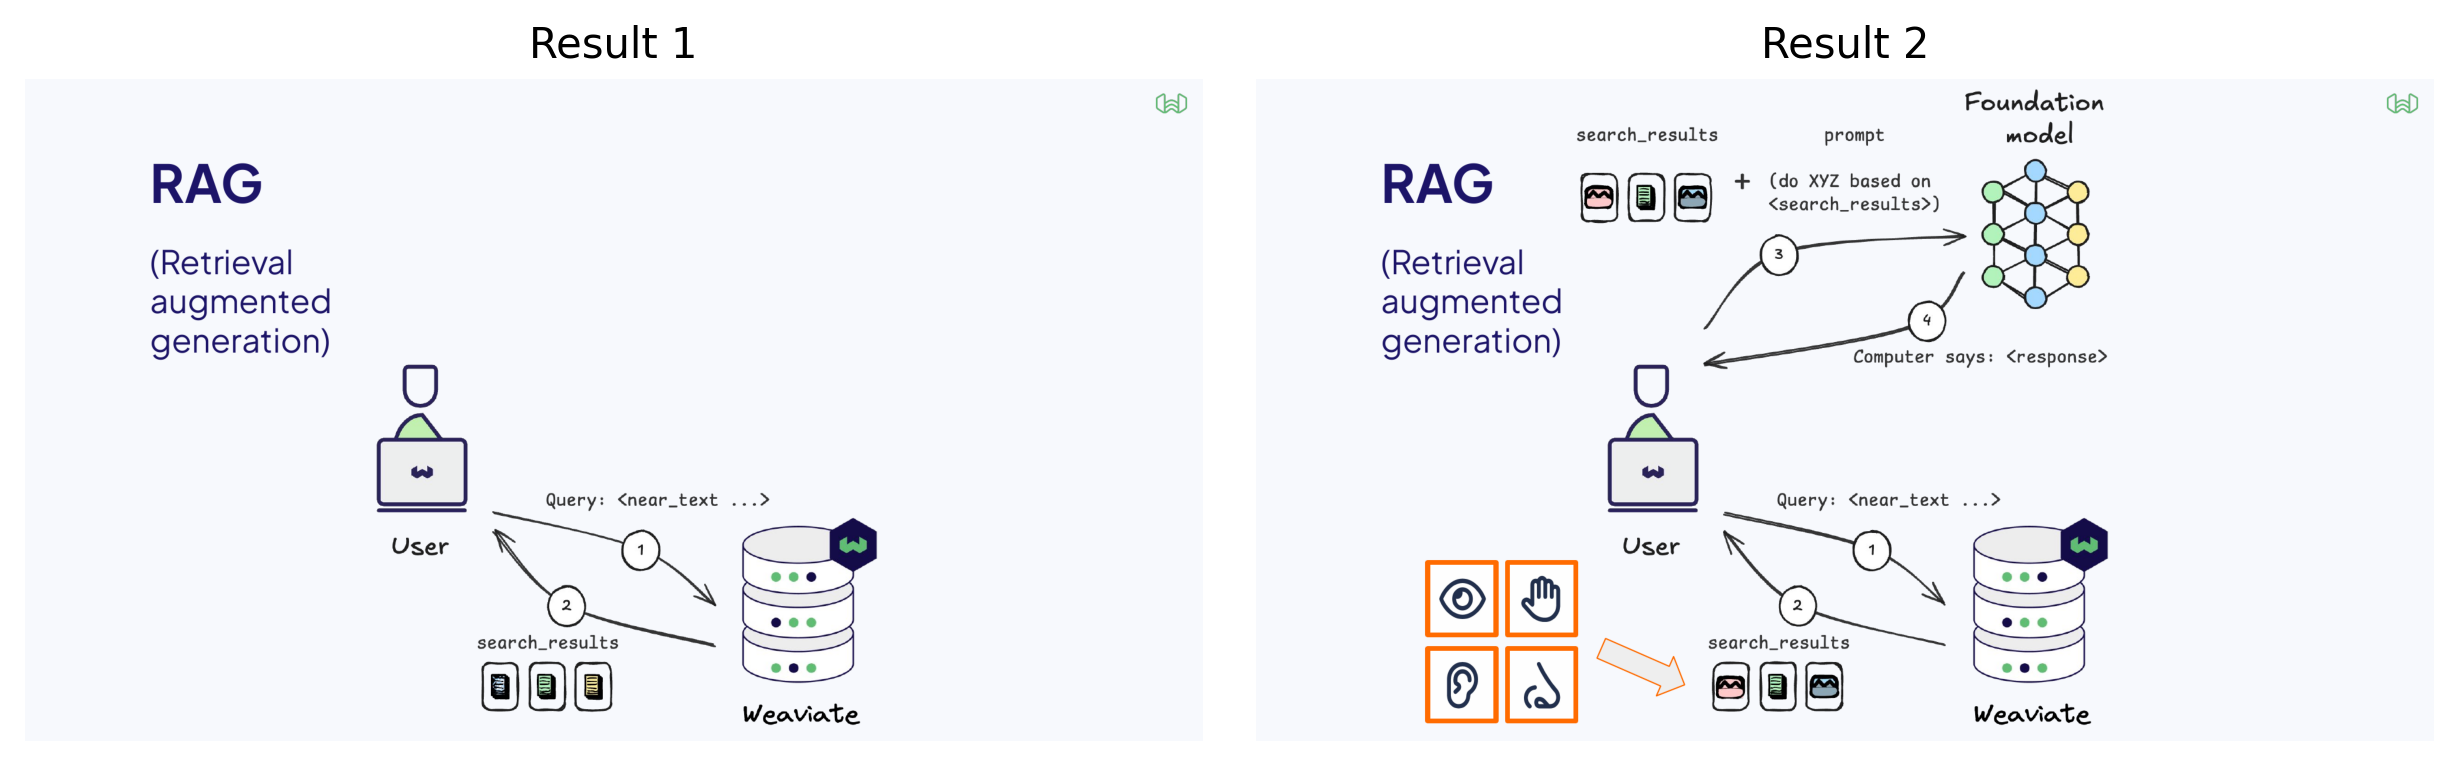

In [10]:
from helpers import show_img_results, text_to_colpali

# Using a pre-defined function for generating ColPali query
query_embeddings = text_to_colpali([
    "retrieval augmented generation multimodal"
], model, processor)

r = collection.query.near_vector(
    near_vector=query_embeddings[0],
    limit=2
)

show_img_results(r)

### How does this work?

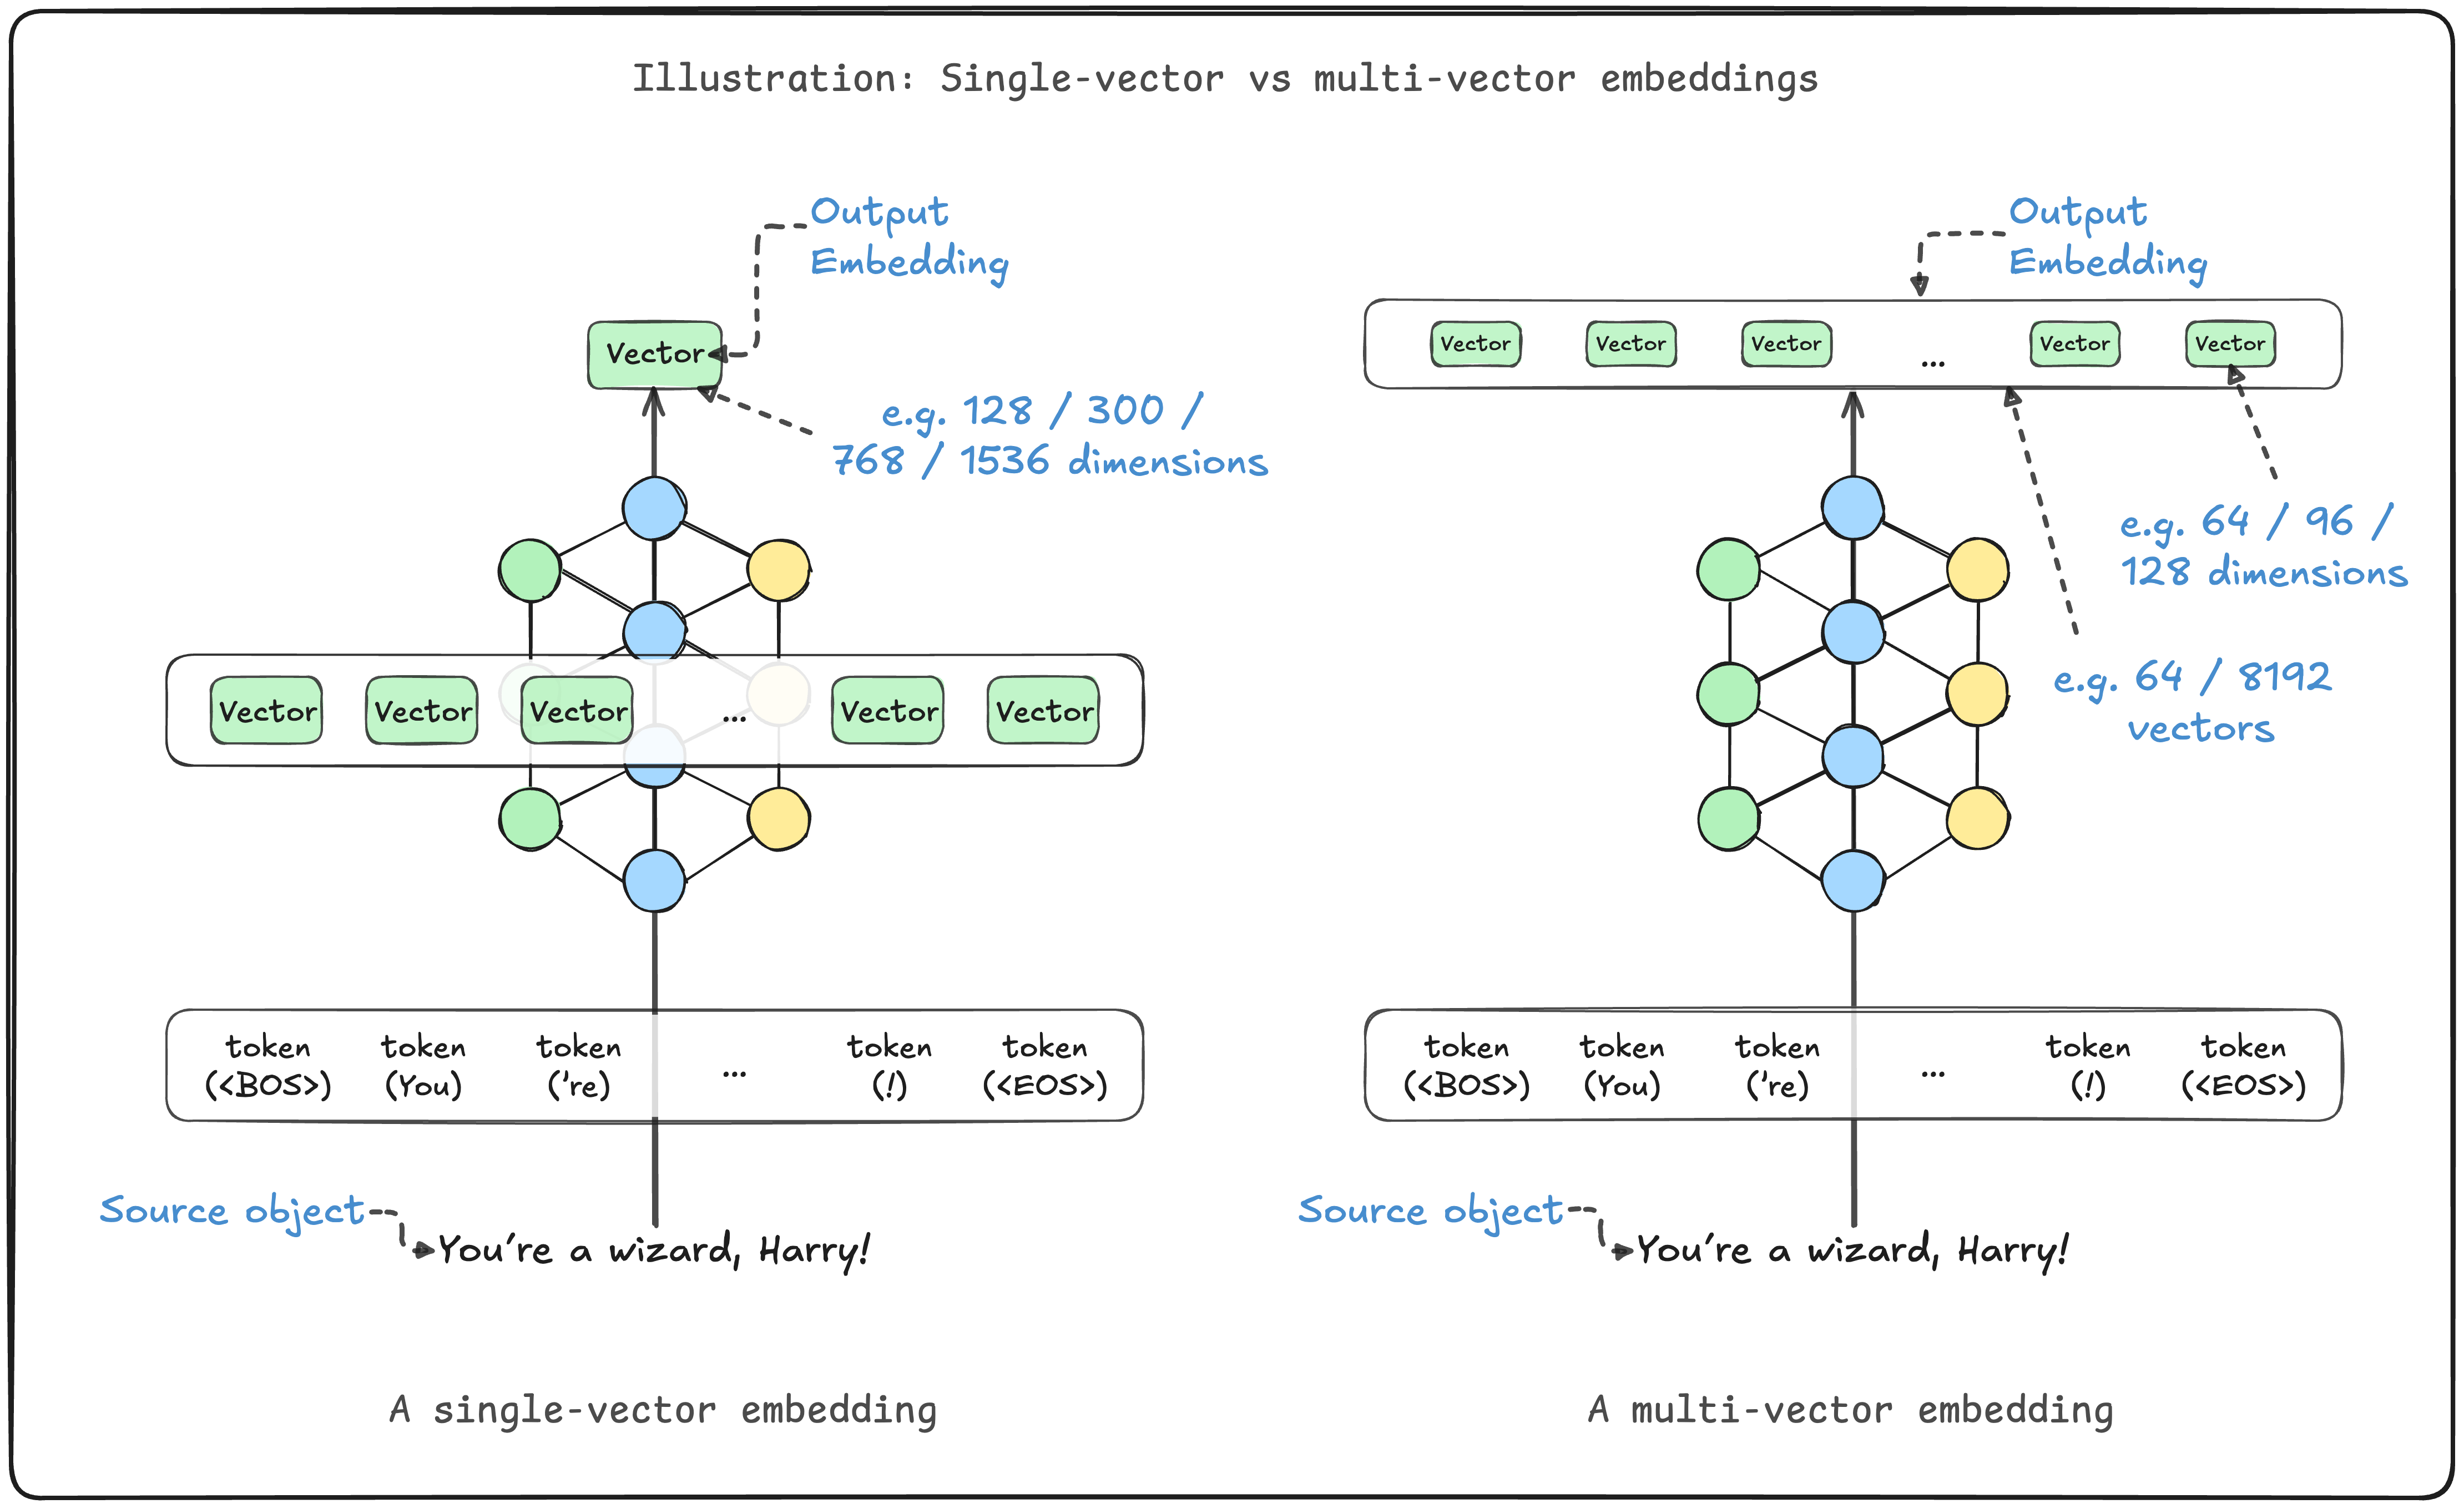

In [11]:
from IPython.display import Image, display

img_w = 600
display(Image('./assets/mv_explained1.png', width=img_w))

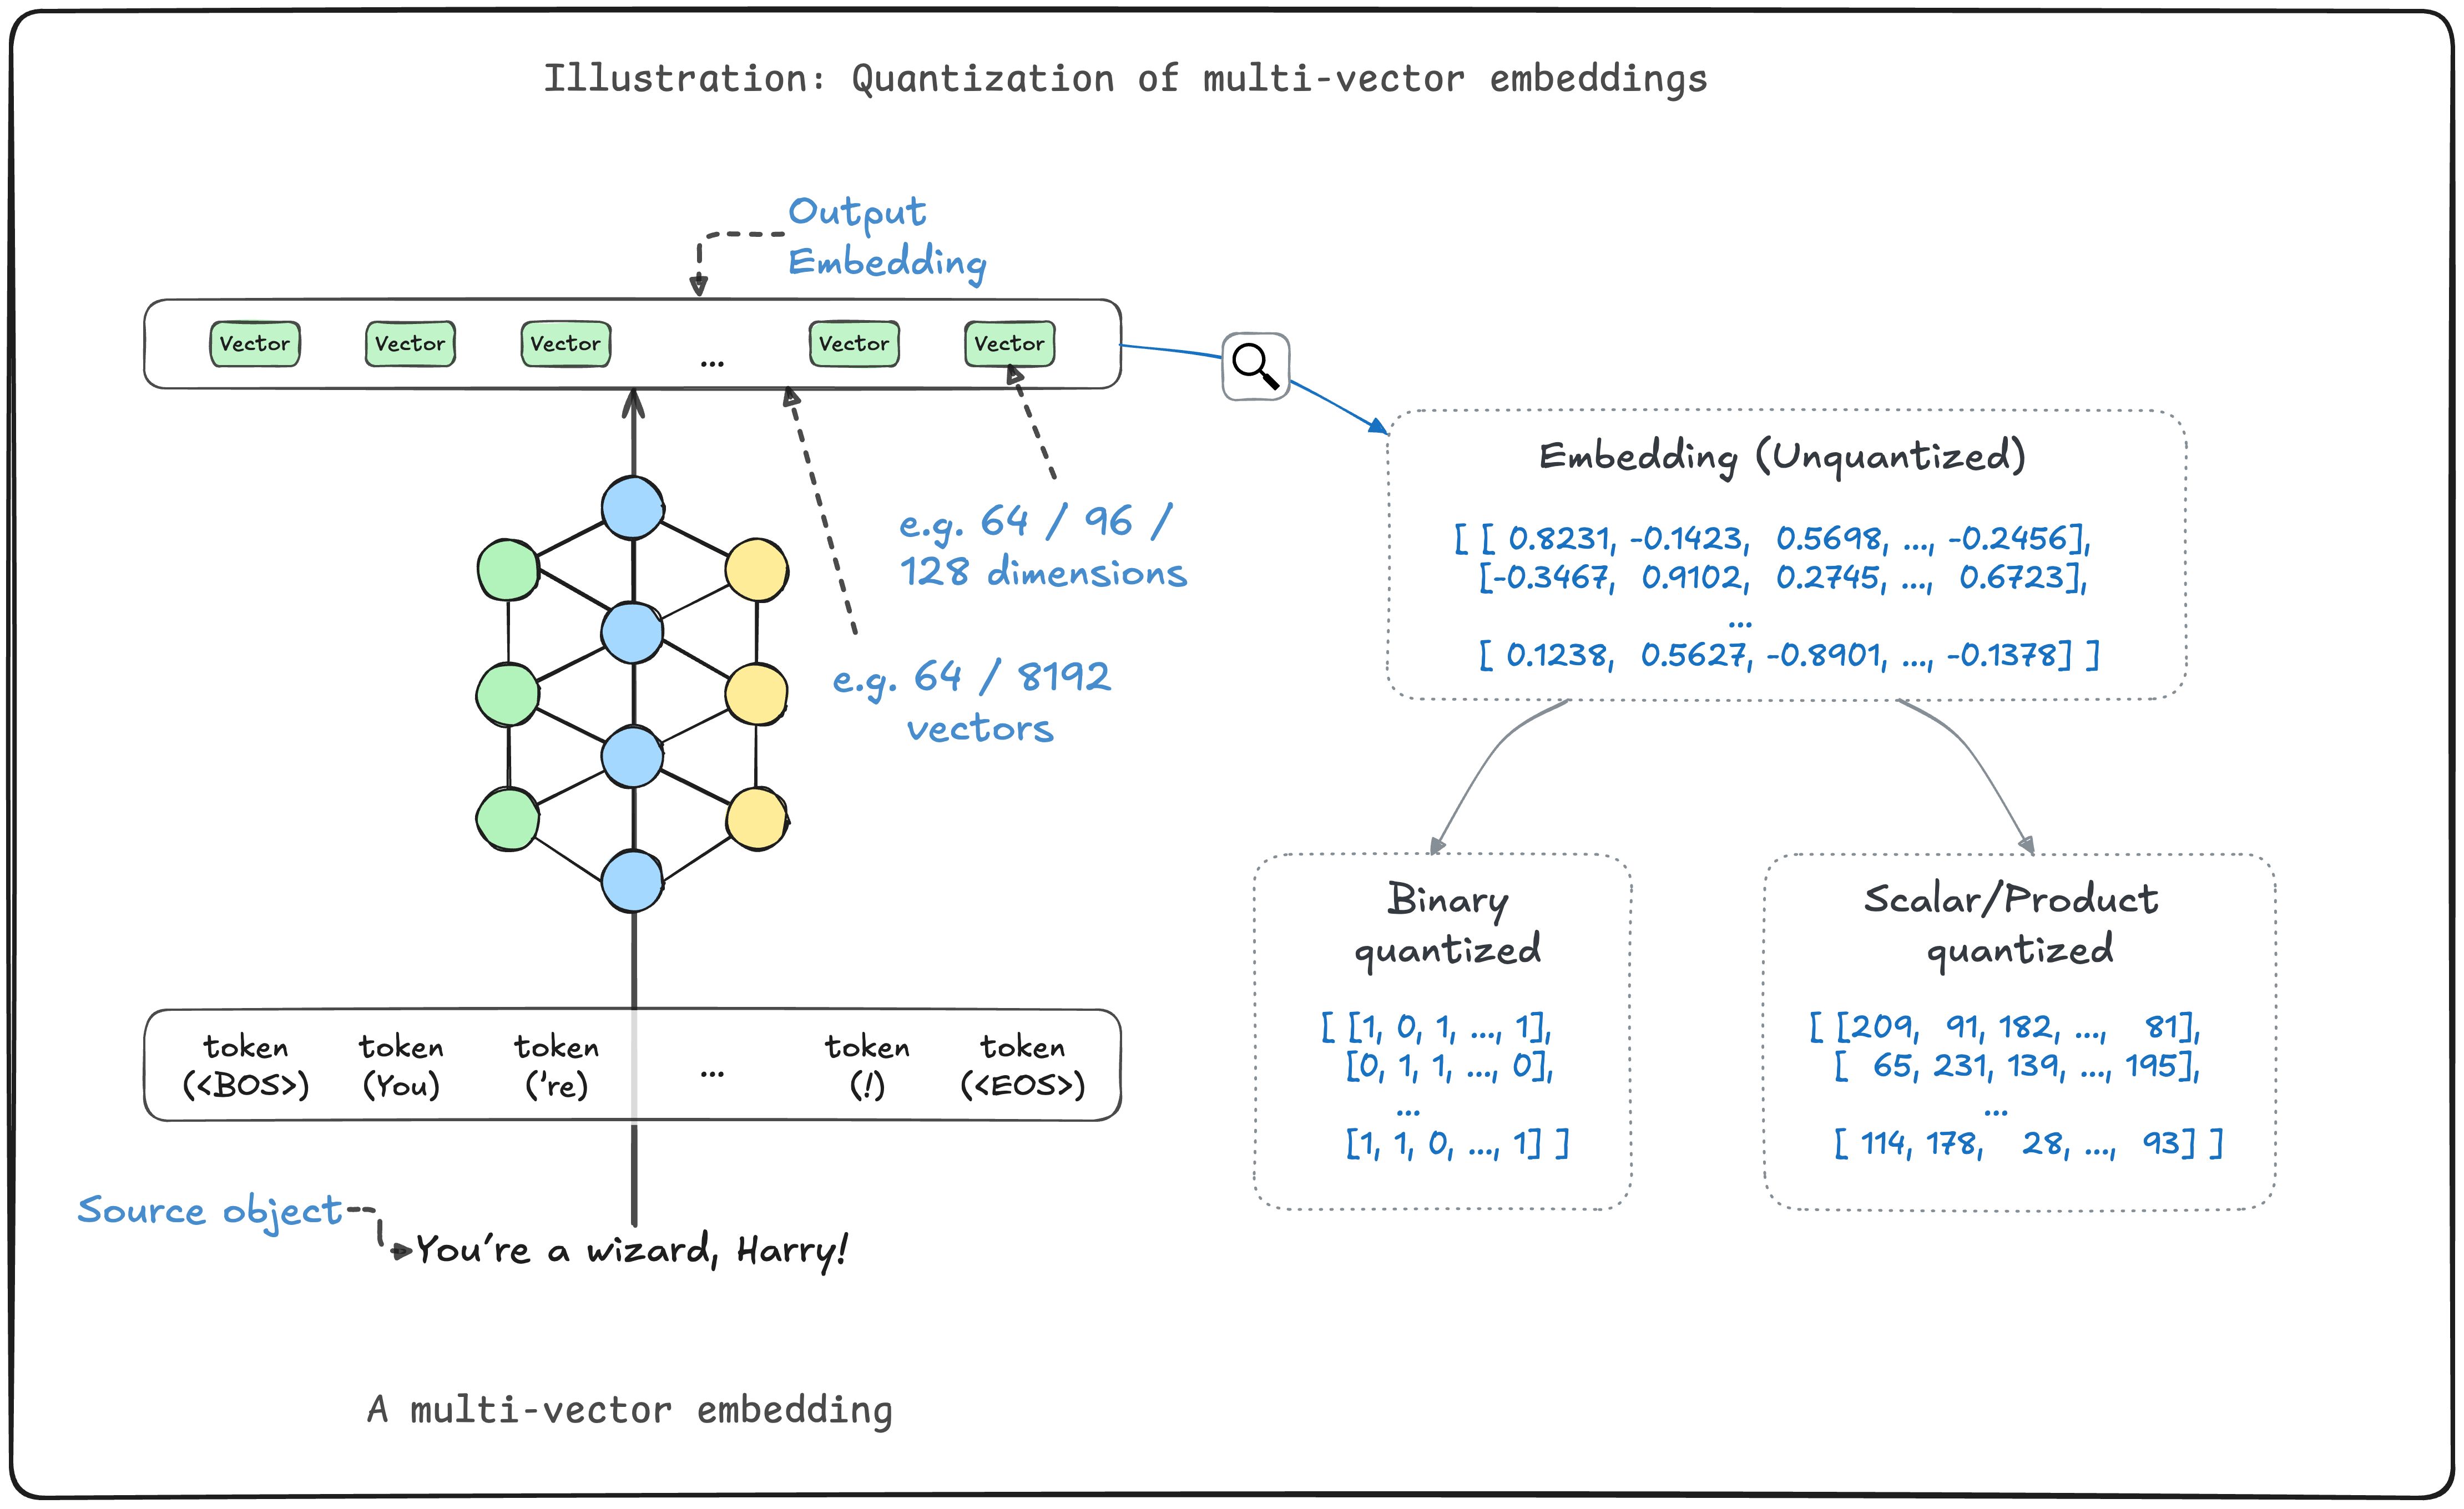

In [12]:
display(Image('./assets/mv_explained2.png', width=img_w))

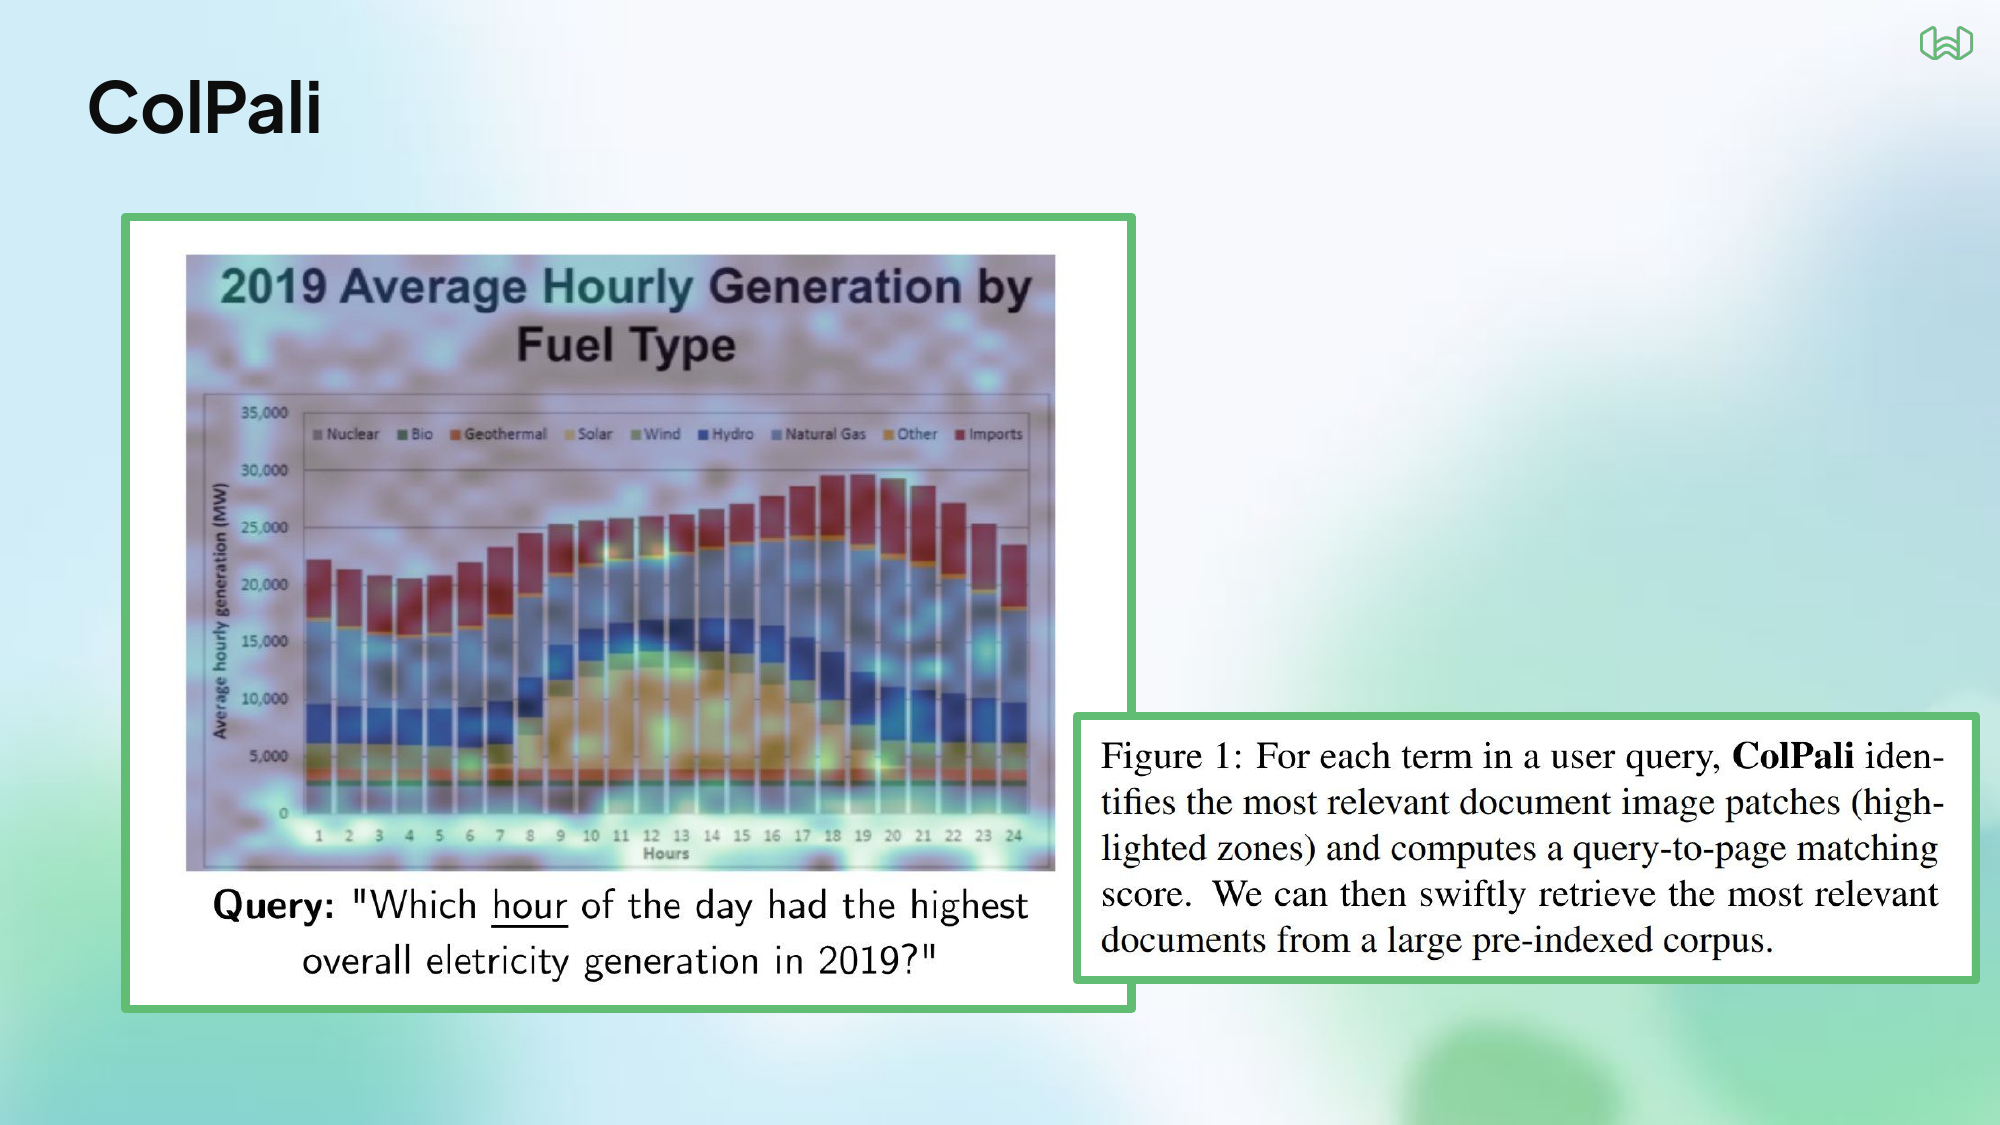

In [13]:
display(Image('data/slides/imgs/202504_roadshow_mm_talk_55_of_60.png', width=img_w))

### One small (big) challenge

In [14]:
for e in embeddings["embeddings"][:3]:
    print("\nembedding shape", e.shape)
    print("embedding dimensions:", e.shape[0] * e.shape[1])
    for r in e[:2]:
        print(r[:2], "...", r[-2:])


embedding shape (1031, 128)
embedding dimensions: 131968
[-0.2421875   0.01806641] ... [-0.14648438  0.05004883]
[ 0.18066406 -0.16113281] ... [ 0.04785156 -0.06787109]

embedding shape (1031, 128)
embedding dimensions: 131968
[-0.09277344  0.13085938] ... [-0.20507812 -0.06201172]
[-0.07958984  0.13964844] ... [-0.20410156 -0.05859375]

embedding shape (1031, 128)
embedding dimensions: 131968
[-0.09716797  0.14648438] ... [-0.140625    0.01806641]
[-0.02258301 -0.05175781] ... [-0.12109375 -0.01422119]


> #### These vectors are very big! (each one with ~130k dimensions - vs typical ~1-2k dimensions)

In [15]:
query_embeddings = text_to_colpali([
    "multimodal embeddings",
], model, processor)

for e in query_embeddings:
    print("\nembedding shape", e.shape)
    print("embedding dimensions:", e.shape[0] * e.shape[1])
    for r in e[:2]:
        print(r[:2], "...", r[-2:])


embedding shape (16, 128)
embedding dimensions: 2048
[-0.001297    0.14746094] ... [-0.21484375 -0.12255859]
[-0.05908203 -0.02624512] ... [-0.1796875   0.07470703]


In [16]:
query_embeddings = text_to_colpali([
    "a detailed explanation of how multi-modal models like ColPali works in vector retrieval",
], model, processor)

for e in query_embeddings:
    print("\nembedding shape", e.shape)
    print("embedding dimensions:", e.shape[0] * e.shape[1])
    for r in e[:2]:
        print(r[:2], "...", r[-2:])


embedding shape (31, 128)
embedding dimensions: 3968
[-0.00210571  0.14746094] ... [-0.21679688 -0.12158203]
[-0.08984375  0.02978516] ... [-0.20605469  0.0625    ]


> #### Even the text vectors are quite large

### Solution: Use MUVERA

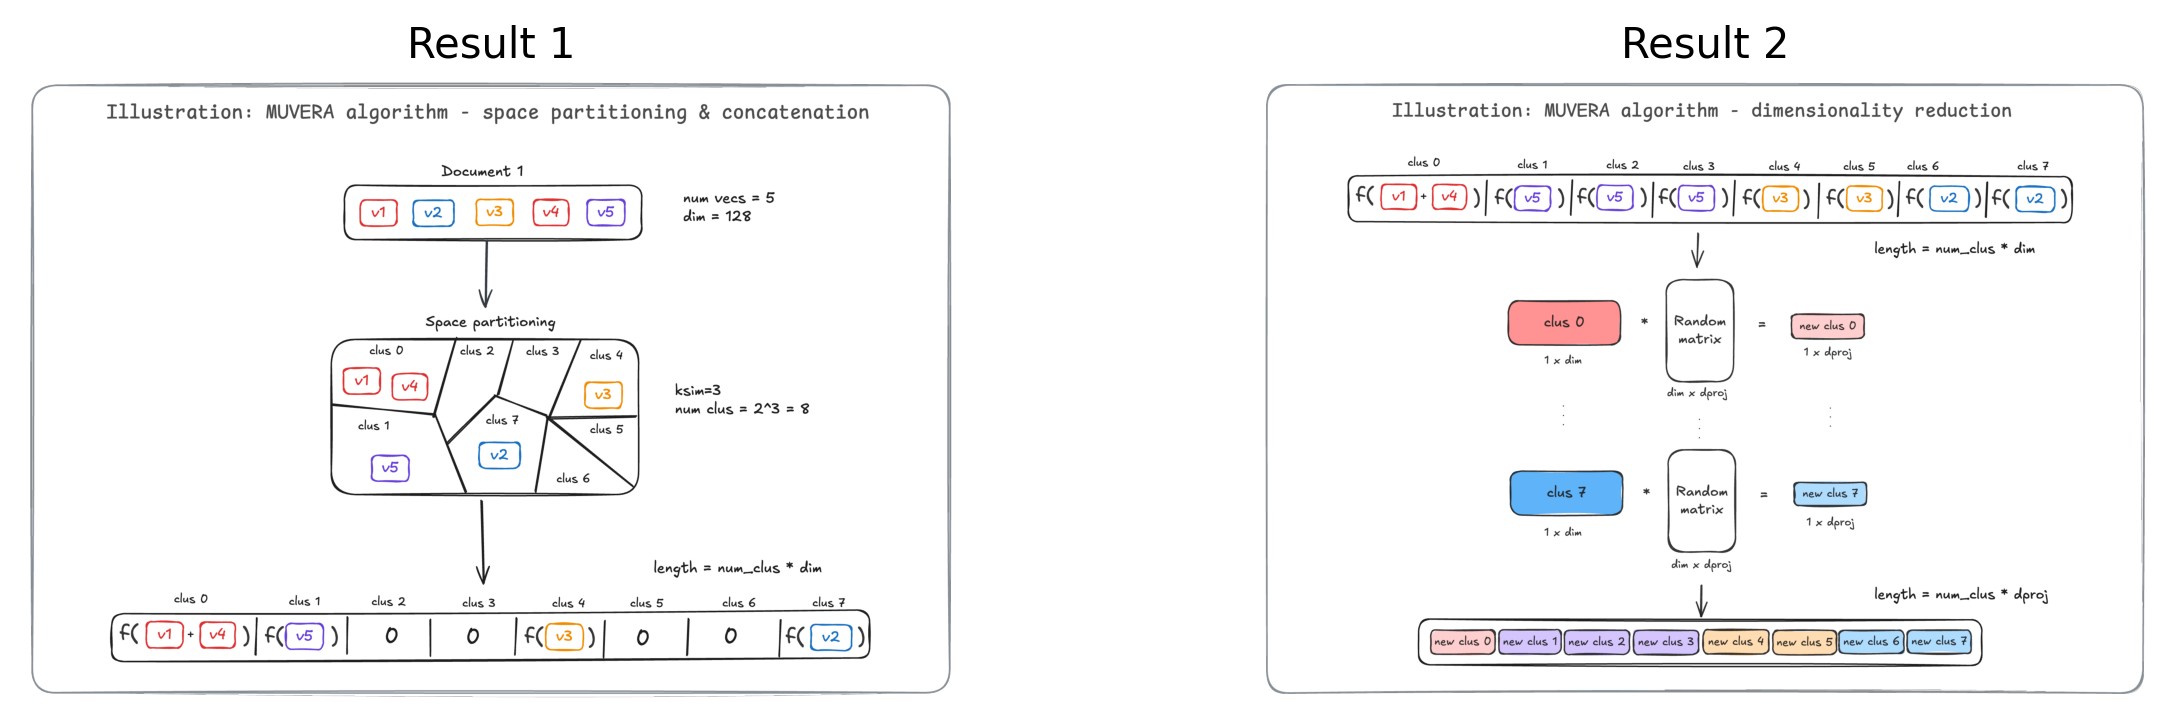

In [17]:
muvera_img_paths = [
    "assets/muvera_algo1.png",
    "assets/muvera_algo3.png",
]

show_local_imgs(muvera_img_paths)

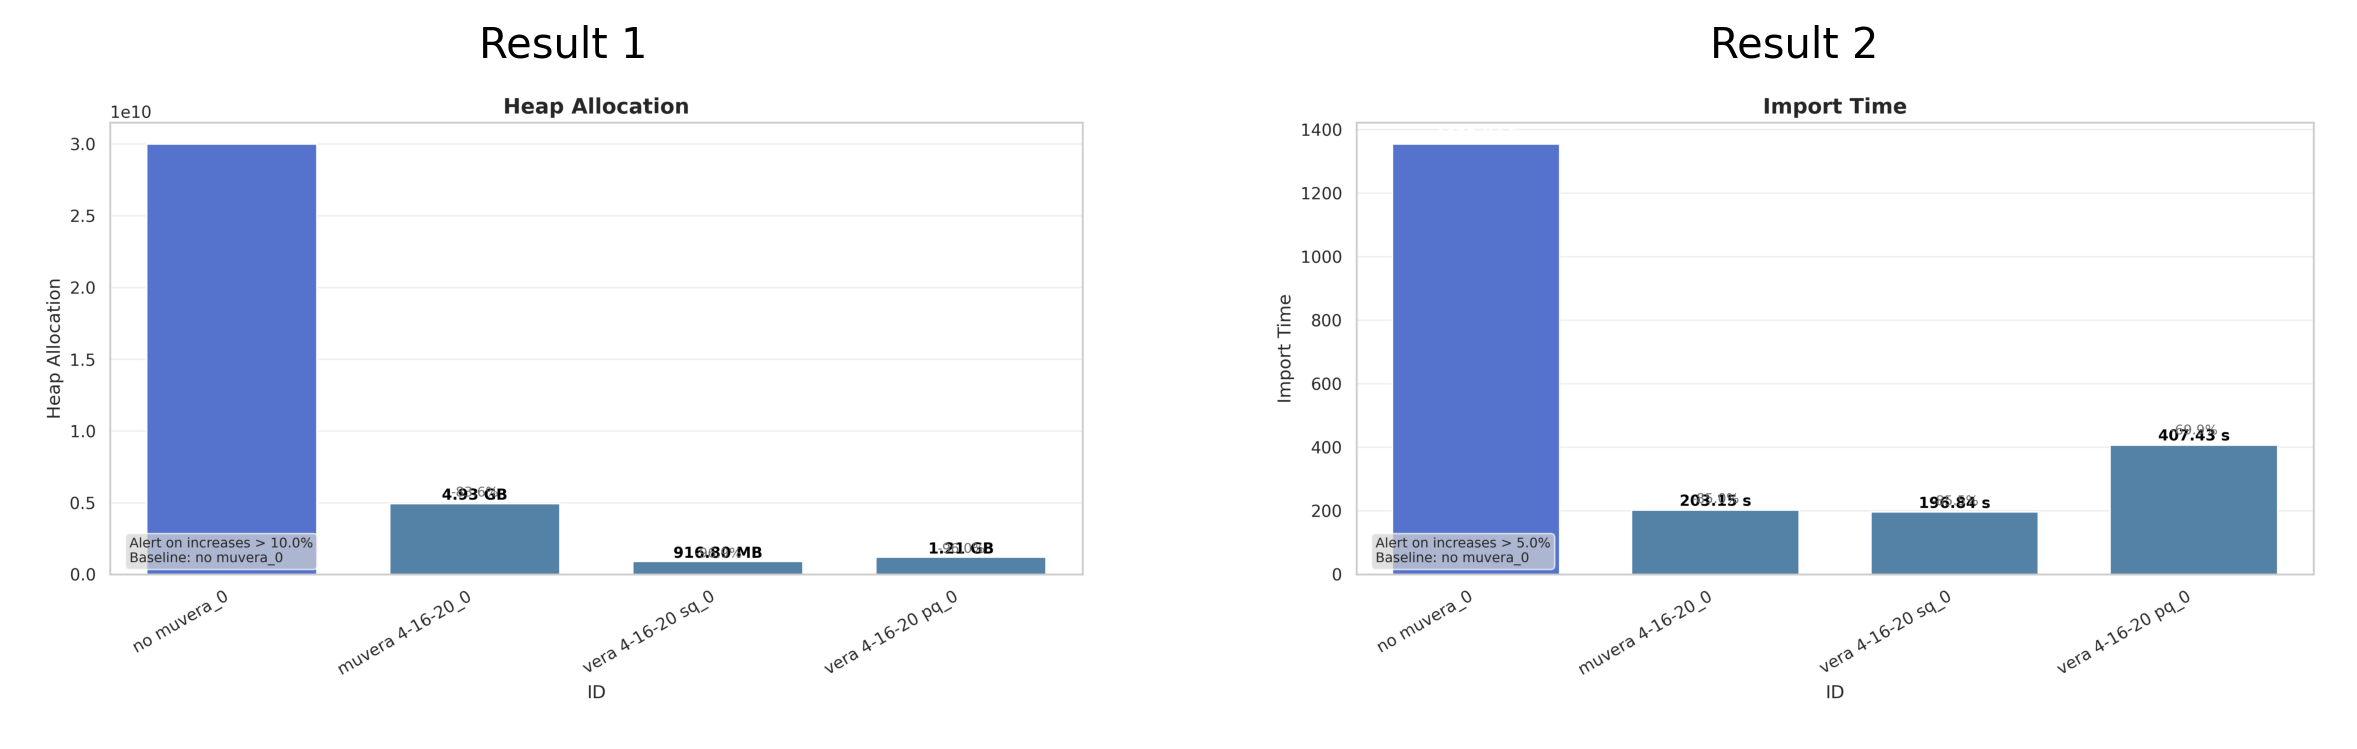

In [18]:
muvera_img_paths = [
    "assets/muvera_test_heap_profile.png",
    "assets/muvera_test_import_time.png",
]

show_local_imgs(muvera_img_paths)

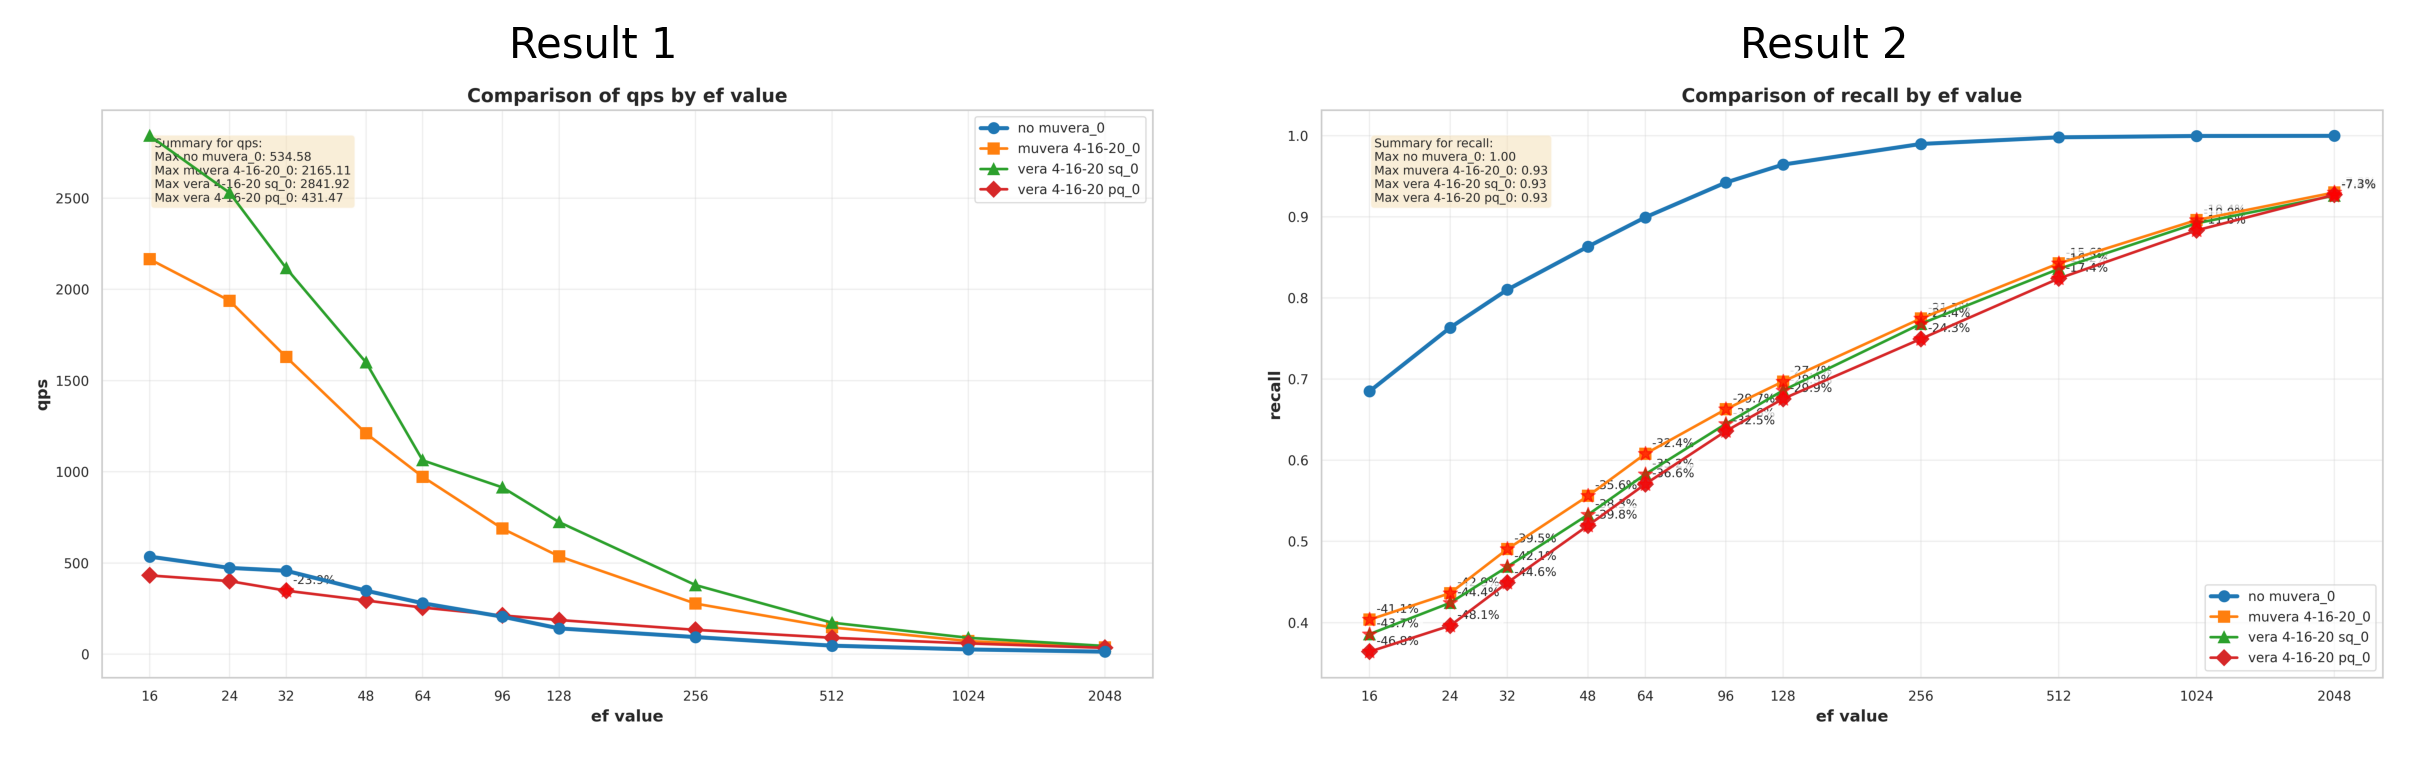

In [19]:
muvera_img_paths = [
    "assets/muvera_test_query1.png",
    "assets/muvera_test_query2.png",
]

show_local_imgs(muvera_img_paths)

#### Enabling MUVERA is quite straightforward!

In [20]:
from weaviate.classes.config import Configure, Property, DataType, Tokenization

collection_name = "TempCollection"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="text", data_type=DataType.TEXT),
        Property(name="image", data_type=DataType.BLOB),
        Property(name="filepath", data_type=DataType.TEXT, tokenization=Tokenization.FIELD),
    ],
    vectorizer_config=[
        Configure.NamedVectors.none(
            name="colpali",  # colpali_v1_3 vector
            vector_index_config=Configure.VectorIndex.hnsw(
                multi_vector=Configure.VectorIndex.MultiVector.multi_vector(
                    encoding=Configure.VectorIndex.MultiVector.Encoding.muvera()
                )
            )
        ),
    ],
    replication_config=Configure.replication(factor=3)
)

/Users/jphwang/code/sandpit/weaviate_enablement_1_31/.venv/lib/python3.12/site-packages/weaviate/collections/classes/config.py:1977: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  for cls_field in self.model_fields:


> #### Then - everything works the same

In [21]:
from tqdm import tqdm

collection = client.collections.get(collection_name)

with collection.batch.fixed_size(20) as batch:
    for i, embedding in tqdm(enumerate(embeddings["embeddings"])):
        filename = embeddings["filepaths"][i].split("/")[-1]
        img_path = imgs_dir/filename
        batch.add_object(
            properties={
                "filepath": str(img_path),
                "image": base64.b64encode(img_path.read_bytes()).decode("utf-8"),
            },
            vector={
                "colpali": embedding
            }
        )

if collection.batch.failed_objects:
    print(collection.batch.failed_objects[0].message)

print(len(collection))

60it [00:01, 45.96it/s]


60


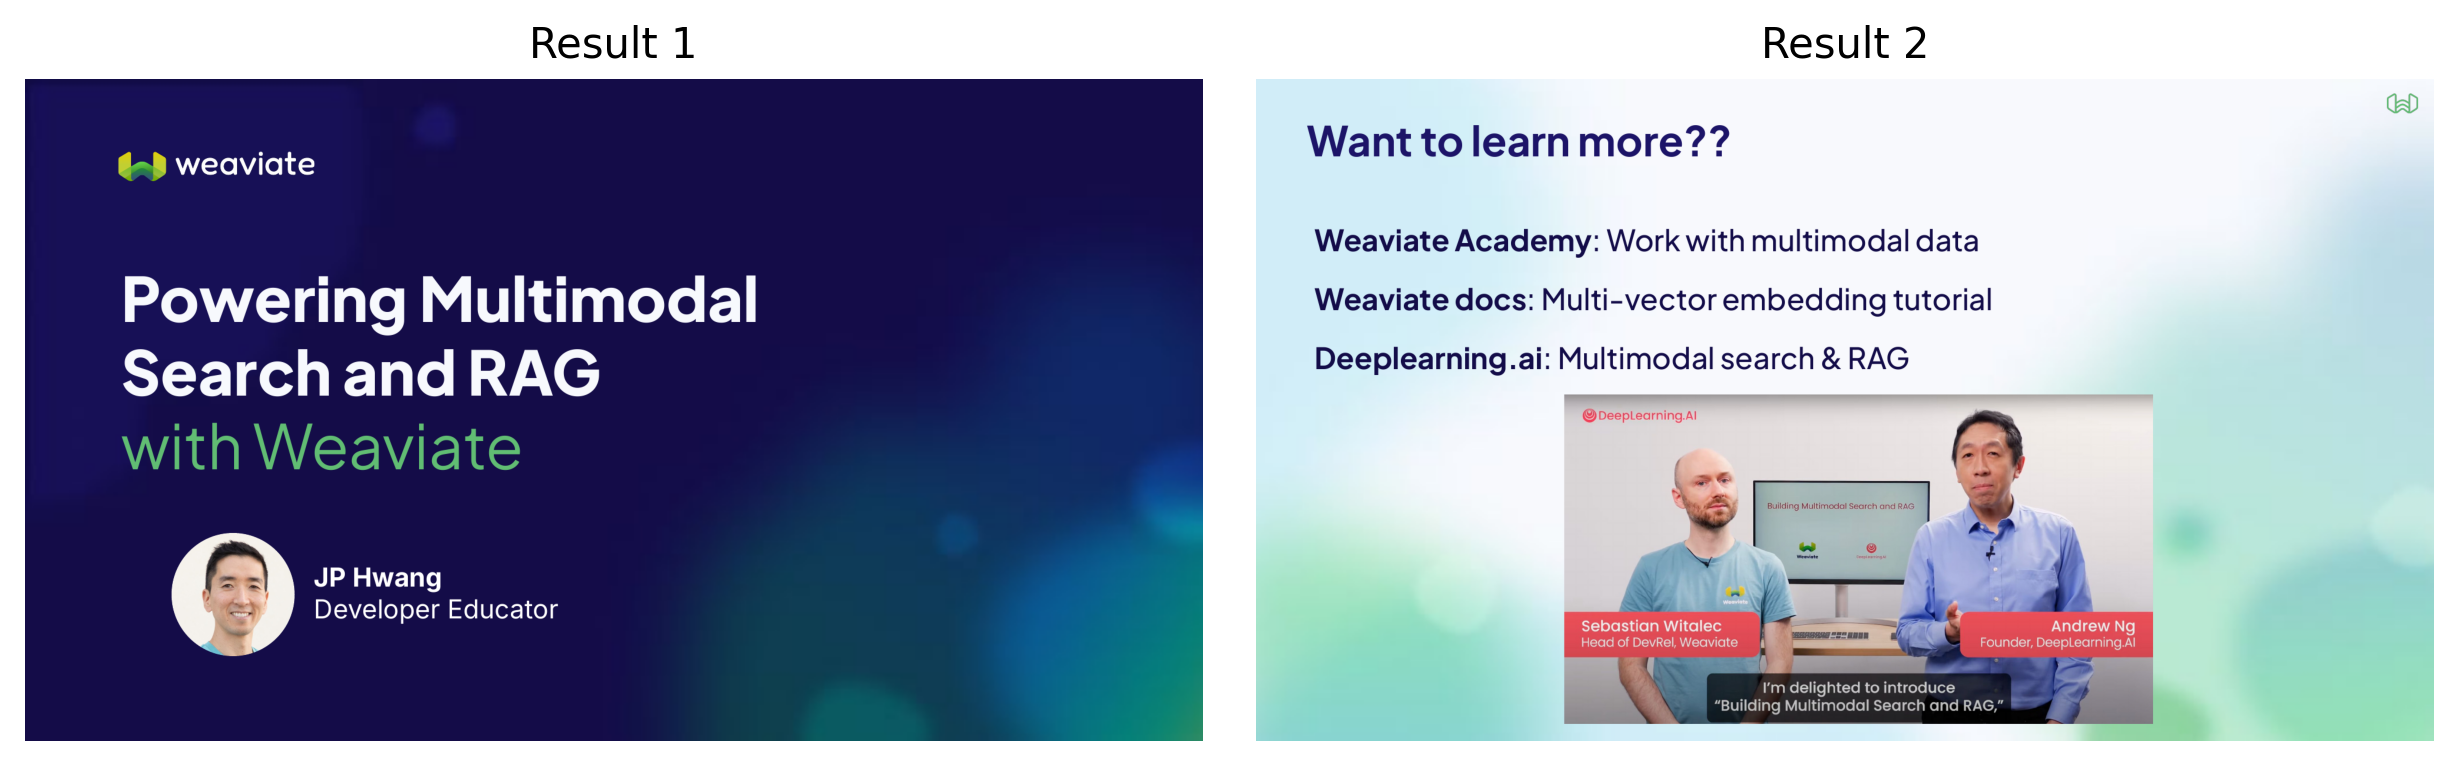

In [25]:
from helpers import show_img_results, text_to_colpali

# Using a pre-defined function for generating ColPali query
query_embeddings = text_to_colpali(["multimodal search"], model, processor)

r = collection.query.near_vector(
    near_vector=query_embeddings[0],
    limit=2
)

show_img_results(r)

## Vectorizer changes

In [26]:
from weaviate.classes.config import Configure, Property, DataType

collection_name = "DemoVecChanges"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        Configure.NamedVectors.text2vec_cohere(
            name="default",
            source_properties=["title", "body"],
        ),
        Configure.NamedVectors.text2vec_cohere(
            name="new_title",
            source_properties=["title"],
        )
    ],
)

In [27]:
c = client.collections.get(collection_name)

cc = c.config.get().vector_config.keys()

print(cc)

dict_keys(['default', 'new_title'])


In [28]:
c.config.add_vector(
    vector_config=Configure.NamedVectors.text2vec_cohere(
        name="body_only",
        source_properties=["body"],
    )
)

In [29]:
c = client.collections.get(collection_name)

cc = c.config.get().vector_config.keys()

print(cc)

dict_keys(['body_only', 'default', 'new_title'])


In [30]:
objects = [
    {"title": "Howl's Moving Castle", "body": "A fantasy novel by Diana Wynne Jones."},
    {"title": "The Hobbit", "body": "A fantasy novel by J.R.R. Tolkien."},
    {"title": "The Hitchhiker's Guide to the Galaxy", "body": "A science fiction novel by Douglas Adams."},
    {"title": "The Great Gatsby", "body": "A novel by F. Scott Fitzgerald."},
]

c = client.collections.get(collection_name)

c.data.insert_many(objects)

BatchObjectReturn(_all_responses=[UUID('3f32aafd-4bf3-4f84-b585-1cdad8067439'), UUID('10ea9251-86ed-4b82-b860-3ac005b7344e'), UUID('30757dd0-c479-4031-ac72-ee8381389345'), UUID('cef4a023-661b-4247-b4c7-f01e17f55c17')], elapsed_seconds=0.33848023414611816, errors={}, uuids={0: UUID('3f32aafd-4bf3-4f84-b585-1cdad8067439'), 1: UUID('10ea9251-86ed-4b82-b860-3ac005b7344e'), 2: UUID('30757dd0-c479-4031-ac72-ee8381389345'), 3: UUID('cef4a023-661b-4247-b4c7-f01e17f55c17')}, has_errors=False)

In [31]:
r = c.query.fetch_objects(limit=1, include_vector=True)

for k, v in r.objects[0].vector.items():
    print(k)
    print(v[:3])

body_only
[-0.0183258056640625, 0.01277923583984375, 0.0241546630859375]
default
[0.00261688232421875, 0.0299224853515625, 0.04571533203125]
new_title
[0.0355224609375, 0.04693603515625, 0.0390625]


### The order matters

In [32]:
from weaviate.classes.config import Configure, Property, DataType

collection_name = "TempCollection"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        Configure.NamedVectors.text2vec_cohere(
            name="default",
            source_properties=["title", "body"],
        ),
        Configure.NamedVectors.text2vec_cohere(
            name="new_title",
            source_properties=["title"],
        )
    ],
)

In [33]:
c = client.collections.get(collection_name)

c.data.insert_many(objects)

BatchObjectReturn(_all_responses=[UUID('182a4e15-41b1-4dac-be2d-6ebe89242ba6'), UUID('e5f11d93-d2d8-4faf-bc9e-18cc9c3ba25f'), UUID('d7e74b1f-37e2-468a-ae27-f24efc729344'), UUID('2420cddf-2d45-45aa-aa63-e9ab2f9391d3')], elapsed_seconds=0.2025749683380127, errors={}, uuids={0: UUID('182a4e15-41b1-4dac-be2d-6ebe89242ba6'), 1: UUID('e5f11d93-d2d8-4faf-bc9e-18cc9c3ba25f'), 2: UUID('d7e74b1f-37e2-468a-ae27-f24efc729344'), 3: UUID('2420cddf-2d45-45aa-aa63-e9ab2f9391d3')}, has_errors=False)

In [34]:
c.config.add_vector(
    vector_config=Configure.NamedVectors.text2vec_cohere(
        name="body_only",
        source_properties=["body"],
    )
)

In [35]:
r = c.query.fetch_objects(limit=1, include_vector=True)

for k, v in r.objects[0].vector.items():
    print(k)
    print(v[:3])

default
[-0.028717041015625, 0.014434814453125, -0.0010528564453125]
new_title
[0.0007386207580566406, 0.0168914794921875, 0.004901885986328125]


## Move shards (Experimental)

Sometimes, you may want to manage how data is distributed in a cluster:

- **Tune performance** - Manually redistribute shards to balance load and optimize query performance
- **Manage capacity** - Move shards to utilize new nodes or free up space on overloaded nodes
- **Operational flexibility** - Drain nodes for maintenance, upgrades, or decommissioning without service impact
- **Optimize costs** - Relocate data to appropriate storage tiers or more cost-effective nodes
- **Troubleshoot** - Isolate problematic data or move shards away from failing hardware

We are starting to add the ability to manually do this (for admins) by introducing shard movement

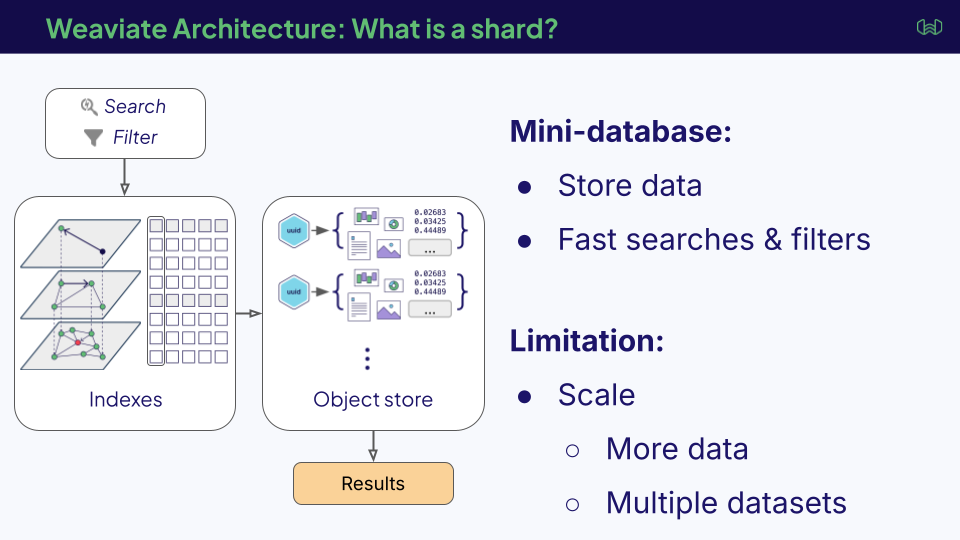

In [36]:
from IPython.display import Image, display

img_w = 600
display(Image('./assets/shards-1.png', width=img_w))

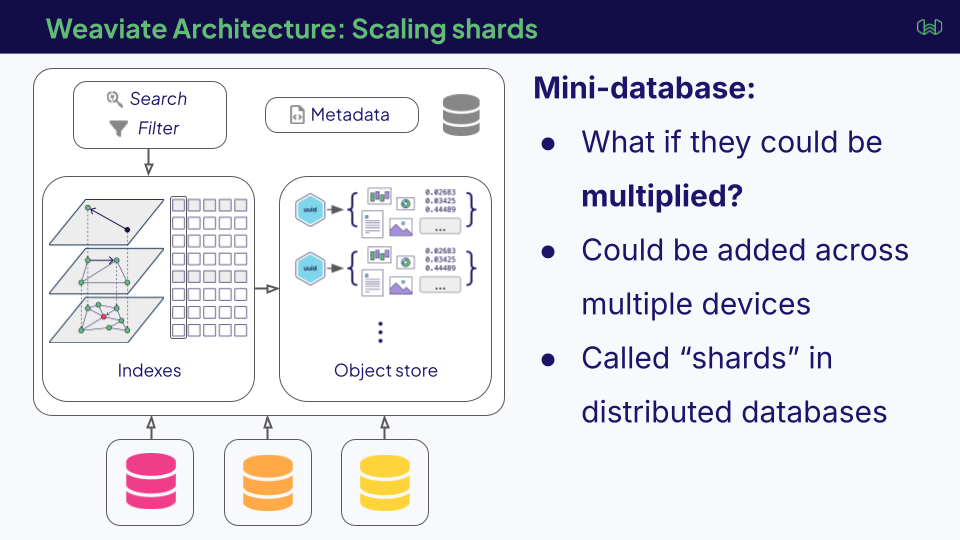

In [37]:
display(Image('./assets/shards-2.png', width=img_w))

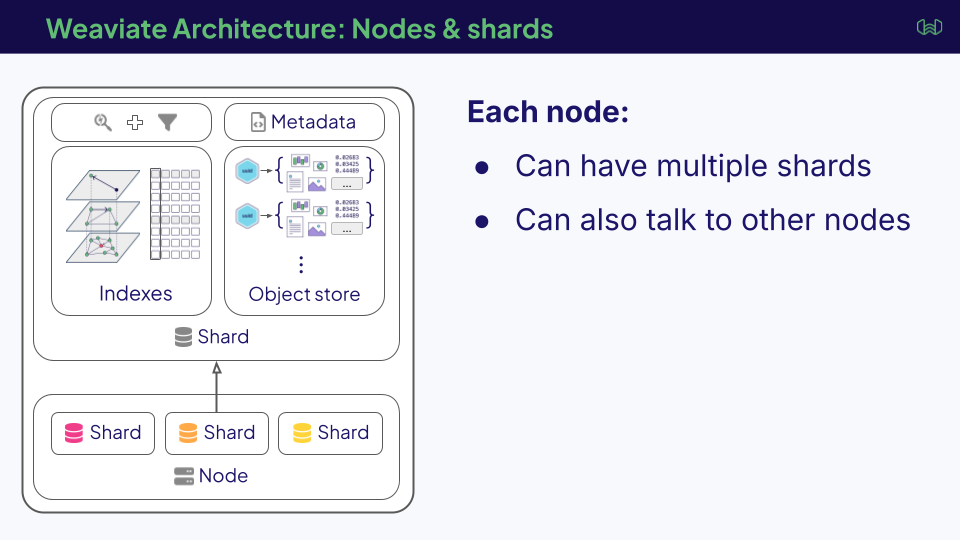

In [38]:
display(Image('./assets/shards-3.png', width=img_w))

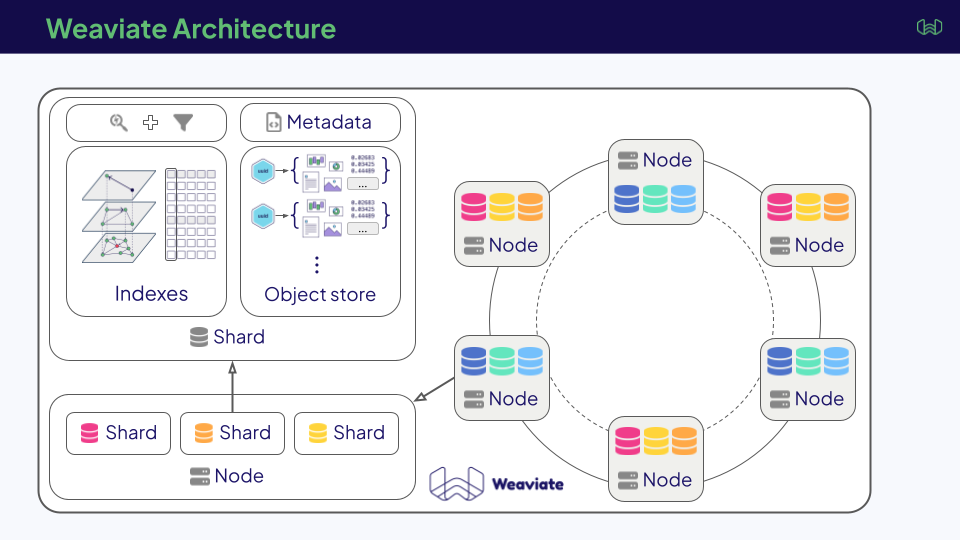

In [39]:
display(Image('./assets/shards-4.png', width=img_w))

Pre-load some data:

In [40]:
from weaviate.classes.config import Configure, Property, DataType

collection_name = "TempCollection"

client.collections.delete(collection_name)

client.collections.create(
    collection_name,
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        Configure.NamedVectors.text2vec_cohere(
            name="default",
            source_properties=["title", "body"],
        ),
    ],
    replication_config=Configure.replication(factor=2),  # Note - this just a demo - do NOT use a RF of 2 in production - use 3 or above odd number
    sharding_config=Configure.sharding(
        desired_count=5  # To demonstrate sharding, we set it to an arbitrary high number (for our dataset size, anyway)
    )
)

c = client.collections.get(collection_name)

objects = [
    {"title": "Howl's Moving Castle", "body": "A fantasy novel by Diana Wynne Jones."},
    {"title": "The Hobbit", "body": "A fantasy novel by J.R.R. Tolkien."},
    {"title": "The Hitchhiker's Guide to the Galaxy", "body": "A science fiction novel by Douglas Adams."},
    {"title": "The Great Gatsby", "body": "A novel by F. Scott Fitzgerald."},
    {"title": "1984", "body": "A dystopian novel by George Orwell."},
    {"title": "To Kill a Mockingbird", "body": "A novel by Harper Lee."},
    {"title": "Pride and Prejudice", "body": "A novel by Jane Austen."},
    {"title": "The Catcher in the Rye", "body": "A novel by J.D. Salinger."},
    {"title": "The Lord of the Rings", "body": "A fantasy novel by J.R.R. Tolkien."},
    {"title": "Brave New World", "body": "A dystopian novel by Aldous Huxley."},
    {"title": "Fahrenheit 451", "body": "A dystopian novel by Ray Bradbury."},
    {"title": "The Picture of Dorian Gray", "body": "A novel by Oscar Wilde."},
]

c.data.insert_many(objects)

import time

start_time = time.time()
print("Waiting for object count to update...")

while True:
    n = client.cluster.nodes(collection=collection_name, output="verbose")[0]
    s = n.shards[0]
    if s.object_count != 0:
        print(f"On node {n.name} and shard {s.name} - obj count: {s.object_count}")
        break
    time.sleep(10)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {elapsed_time:.1f}s")

finish_time = time.time()
print(f"Time taken for obj count to update: {finish_time - start_time} seconds")

Waiting for object count to update...
Elapsed time: 10.0s
Elapsed time: 20.0s
Elapsed time: 30.0s
Elapsed time: 40.0s
Elapsed time: 50.1s
Elapsed time: 60.1s
On node node1 and shard AXxEWRZHWbXF - obj count: 4
Time taken for obj count to update: 60.064892292022705 seconds


In [41]:
len(c)

12

In [42]:
nodes_response = client.cluster.nodes(collection=collection_name, output="verbose")

for n in nodes_response:
    print(f"\nNode {n.name} has {len(n.shards)} shards")
    for s in n.shards:
        print(f"Shard {s.name} has {s.object_count} objects from {collection_name}")


Node node1 has 4 shards
Shard AXxEWRZHWbXF has 4 objects from TempCollection
Shard HwjB0p0TAv9q has 2 objects from TempCollection
Shard wlYgWdRGhdKk has 2 objects from TempCollection
Shard VlAa2N0DHEBY has 0 objects from TempCollection

Node node2 has 3 shards
Shard wlYgWdRGhdKk has 2 objects from TempCollection
Shard VlAa2N0DHEBY has 0 objects from TempCollection
Shard KrdtkmoUNmJ1 has 4 objects from TempCollection

Node node3 has 3 shards
Shard HwjB0p0TAv9q has 2 objects from TempCollection
Shard AXxEWRZHWbXF has 4 objects from TempCollection
Shard KrdtkmoUNmJ1 has 4 objects from TempCollection


In [43]:
n = nodes_response[0]
candidate_shard = None
for src_shard in n.shards:
    node2_shards = [
        n2_shard.name for n2_shard in nodes_response[1].shards
    ]
    if src_shard.name not in node2_shards:
        candidate_shard = src_shard
        break

print(f"Candidate shard to move: {candidate_shard.name}")

SHARD_ID = candidate_shard.name

Candidate shard to move: AXxEWRZHWbXF


In [ ]:
import requests
import json

# Shard move parameters
SOURCE_NODE = "node1"
DESTINATION_NODE = "node2"

# Create the request payload
payload = {
    "sourceNodeName": "node1",
    "destinationNodeName": DESTINATION_NODE,
    "collectionId": collection_name,
    "shardId": SHARD_ID,
    "transferType": "COPY"  # Use "MOVE" to relocate the shard, or "COPY" to replicate it
}

# Set up the headers
headers = {
    "Content-Type": "application/json"
}

# Make the API request
response = requests.post(
    f"http://localhost:8080/v1/replication/replicate",
    headers=headers,
    data=json.dumps(payload)
)

operation_id = response.json().get("id")

# Check for the status of the operation
response = requests.get(
    f"http://localhost:8080/v1/replication/replicate/{operation_id}",
    headers=headers,
)

print(response.json())
print("Shard move operation status:")
print(f'Status: {response.json()["status"]["state"]}')

{'collection': 'TempCollection', 'id': 'b8d4da30-77fb-4f92-a6d6-83025cbcfac0', 'shardId': 'AXxEWRZHWbXF', 'sourceNodeId': 'node1', 'status': {'errors': None, 'state': 'REGISTERED'}, 'statusHistory': None, 'targetNodeId': 'node2', 'transferType': 'MOVE'}
Shard move operation status:
Status: REGISTERED


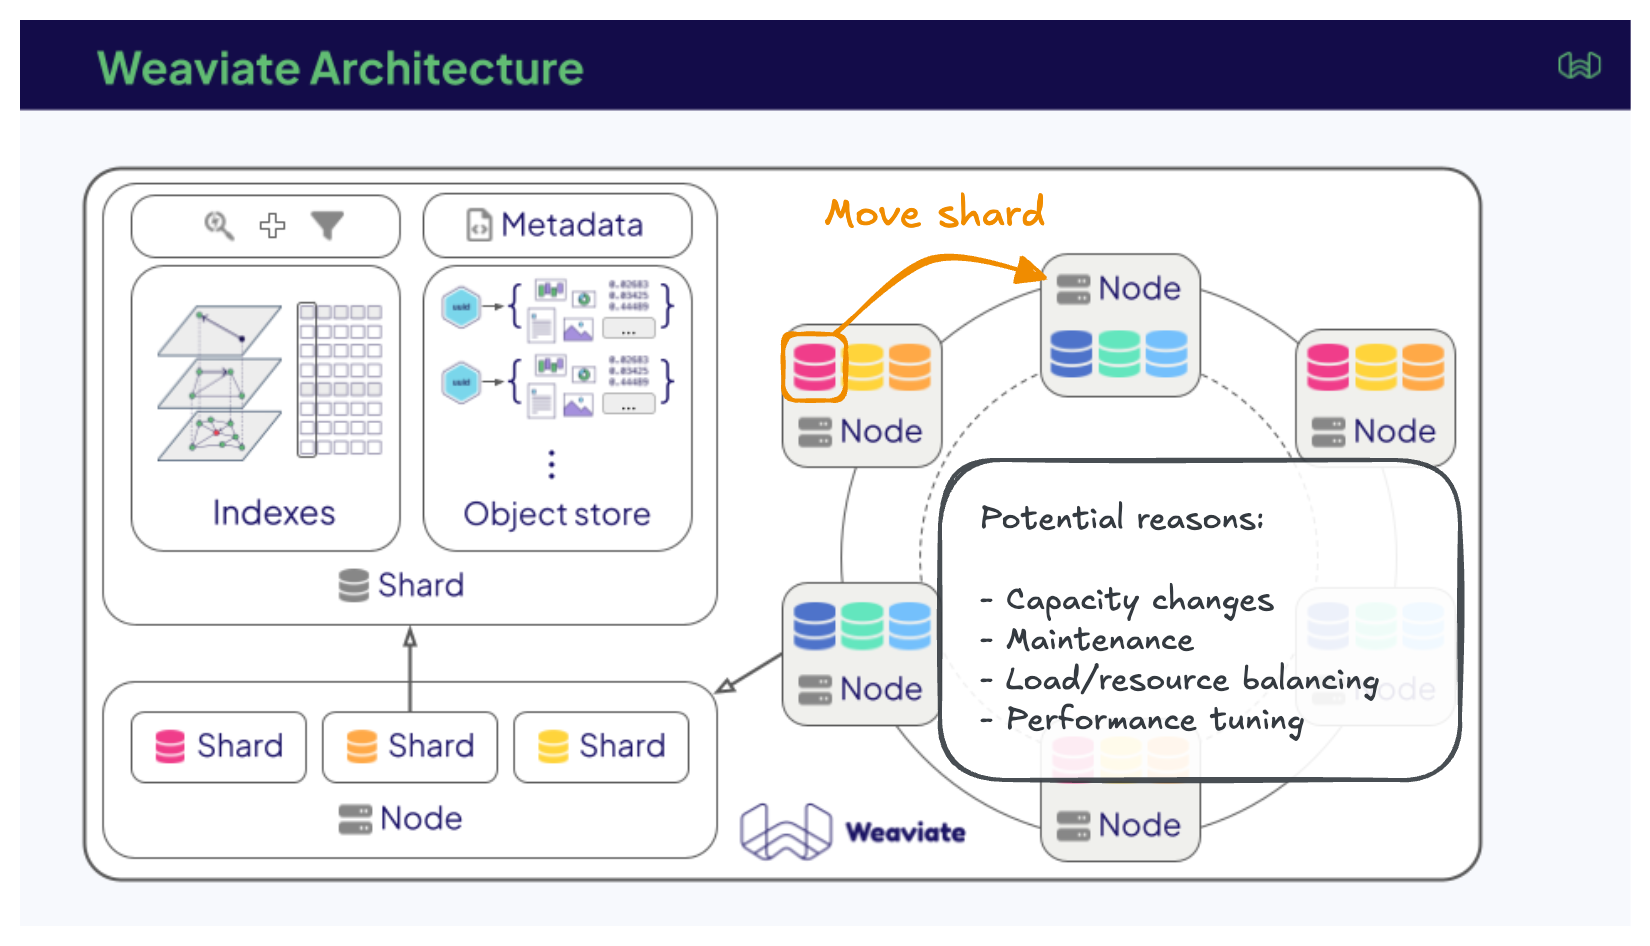

In [51]:
display(Image('./assets/shards-5.png', width=img_w))

Check the status to see if it's finished:

In [53]:
# Check for the status of the operation
response = requests.get(
    f"http://localhost:8080/v1/replication/replicate/{operation_id}",
    headers=headers,
)

print(response.json())
print("Shard move operation status:")
print(f'Status: {response.json()["status"]["state"]}')

{'collection': 'TempCollection', 'id': 'b8d4da30-77fb-4f92-a6d6-83025cbcfac0', 'shardId': 'AXxEWRZHWbXF', 'sourceNodeId': 'node1', 'status': {'errors': None, 'state': 'REGISTERED'}, 'statusHistory': None, 'targetNodeId': 'node2', 'transferType': 'MOVE'}
Shard move operation status:
Status: REGISTERED


In [54]:
for n in client.cluster.nodes(collection=collection_name, output="verbose"):
    print(f"\nNode {n.name} has {len(n.shards)} shards")
    for s in n.shards:
        print(f"Shard {s.name} has {s.object_count} objects from {collection_name}")


Node node1 has 4 shards
Shard AXxEWRZHWbXF has 4 objects from TempCollection
Shard HwjB0p0TAv9q has 2 objects from TempCollection
Shard wlYgWdRGhdKk has 2 objects from TempCollection
Shard VlAa2N0DHEBY has 0 objects from TempCollection

Node node2 has 3 shards
Shard VlAa2N0DHEBY has 0 objects from TempCollection
Shard wlYgWdRGhdKk has 2 objects from TempCollection
Shard KrdtkmoUNmJ1 has 4 objects from TempCollection

Node node3 has 3 shards
Shard KrdtkmoUNmJ1 has 4 objects from TempCollection
Shard AXxEWRZHWbXF has 4 objects from TempCollection
Shard HwjB0p0TAv9q has 2 objects from TempCollection
